In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv("Data\\train.csv")

data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


kaggle problem link: https://www.kaggle.com/c/titanic

# Visualizing Data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.

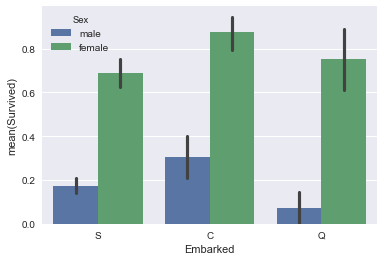

In [2]:
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=data_train)

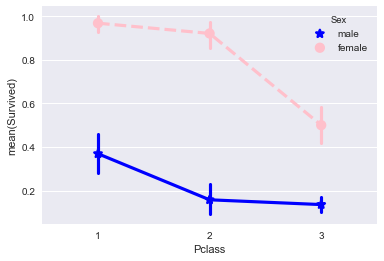

In [3]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

# Tranforming features
1.Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, I'm grouping people into logical human age groups.
<br>2.Each Cabin starts with a letter. I bet this letter is much more important than the number that follows, let's slice it off.

<br>3.Fare is another continuous value that should be simplified. I ran data_train.Fare.describe() to get the distribution of the feature, then placed them into quartile bins accordingly.

<br>4.Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name and name prefix (Mr. Mrs. Etc.), then appended them as their own features.

<br>5.Lastly, drop useless features. (Ticket and Name)

In [8]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return  df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df   

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


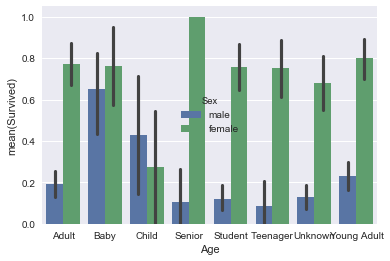

In [4]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

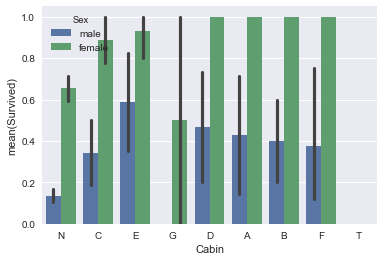

In [6]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

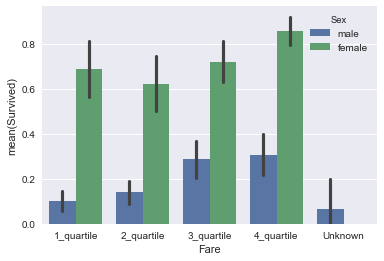

In [7]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

# Some Final Encoding
The last part of the preprocessing phase is to normalize labels. The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.
<br><br>
The result is a table of numbers that looks scary to humans, but beautiful to machines.



In [9]:
from sklearn import preprocessing
def encode_features(df_train,df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex','Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
data_train, data_test = encode_features(data_train, data_test)
data_train.head()
    

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


# Splitting up the training data

Now its time for some Machine Learning.

First, separate the features(X) from the labels(y).

X_all: All features minus the value we want to predict (Survived).

y_all: Only the value we want to predict.

Second, use Scikit-learn to randomly shuffle this data into four variables. In this case, I'm training 80% of the data, then testing against the other 20%.

Later, this data will be reorganized into a KFold pattern to validate the effectiveness of a trained algorithm.

In [10]:
from sklearn.model_selection import train_test_split
X_all = data_train.drop(['Survived','PassengerId','Lname'],axis =1)
y_all = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=23)
X_all.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,NamePrefix
0,3,1,4,1,0,0,7,19
1,1,0,0,1,0,3,2,20
2,3,0,7,0,0,0,7,16
3,1,0,7,1,0,3,2,20
4,3,1,7,0,0,1,7,19


# Building Artificial Neural Network

So, now i will be using the 2 Layers Neural Network Model using the Keras with tensorflow background.

Keras: https://keras.io/ <br>
Tensorflow: https://www.tensorflow.org/

### Importing Libraries

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

In [12]:
print(X_train.shape)
print(y_train.shape)

(712, 8)
(712,)


In [29]:
model = Sequential()

#Adding the input layer and the first hidden layer
model.add(Dense(6,kernel_initializer='uniform',input_shape =(8,)))

#adding Activation Function
model.add(Activation('relu'))

#Adding the secong layer
model.add(Dense(6))
model.add(Activation('relu'))

#Adding the output Layer
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 6)                 54        
_________________________________________________________________
activation_9 (Activation)    (None, 6)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 42        
_________________________________________________________________
activation_10 (Activation)   (None, 6)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


### Training our model

Keras Model: https://keras.io/models/model/

In [31]:
model.fit(X_train,y_train, batch_size = 10, epochs=20, validation_data=(X_test,y_test))

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 0s 77us/step - loss: 0.5601 - acc: 0.7121 - val_loss: 1.2956 - val_acc: 0.3631
Epoch 2/20
712/712 [==============================] - 0s 71us/step - loss: 0.5792 - acc: 0.6980 - val_loss: 0.9636 - val_acc: 0.3631
Epoch 3/20
712/712 [==============================] - 0s 73us/step - loss: 0.5821 - acc: 0.6938 - val_loss: 0.6466 - val_acc: 0.6592
Epoch 4/20
712/712 [==============================] - 0s 71us/step - loss: 0.5538 - acc: 0.7177 - val_loss: 0.5015 - val_acc: 0.7318
Epoch 5/20
712/712 [==============================] - 0s 69us/step - loss: 0.5655 - acc: 0.6966 - val_loss: 0.4879 - val_acc: 0.7821
Epoch 6/20
712/712 [==============================] - 0s 70us/step - loss: 0.5567 - acc: 0.7247 - val_loss: 0.4932 - val_acc: 0.7542
Epoch 7/20
712/712 [==============================] - 0s 69us/step - loss: 0.5541 - acc: 0.7191 - val_loss: 0.5075 - val_acc: 0.7542
Epoch 8/20
712/712 [===

In [34]:
y_pred = model.predict(X_test)
y_pred[2]

array([0.14645933], dtype=float32)

In [35]:
y_pred = (y_pred>0.5)

### Confusion Matrix

In [102]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [103]:
cm

array([[100,  15],
       [ 23,  41]], dtype=int64)

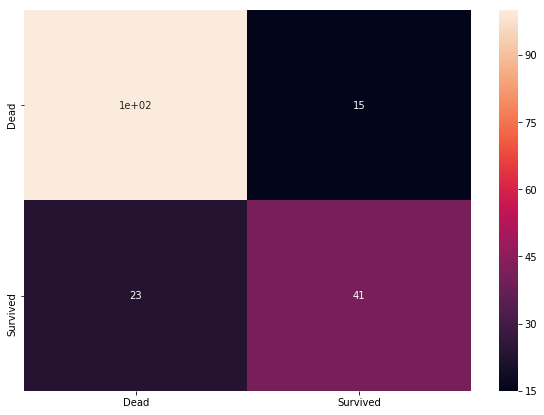

In [104]:
import seaborn as sns
plt.figure(figsize = (10,7))
cm = pd.DataFrame(cm,index = ['Dead','Survived'],columns = ['Dead','Survived'])
sns.heatmap(cm, annot=True)

# Validate with KFOLD

Is this model actually any good? It helps to verify the effectiveness of the algorithm using KFold. This will split our data into 10 buckets, then run the algorithm using a different bucket as the test set for each iteration.

K-fold cross validation is performed as per the following steps:

1.Partition the original training data set into k equal subsets. Each subset is called a fold. Let the folds be named as f1, f2, …, fk.<br>
2.For i = 1 to i = k<br>
   &nbsp; a. Keep the fold fi as Validation set and keep all the remaining k-1 folds in the Cross validation training set.<br>
   &nbsp; b. Train your machine learning model using the cross validation training set and calculate the accuracy of your model by            validating the predicted results against the validation set.<br>
3.Estimate the accuracy of your machine learning model by averaging the accuracies derived in all the k cases of cross validation.
<br>
In the k-fold cross validation method, all the entries in the original training data set are used for both training as well as validation. Also, each entry is used for validation just once.

In [44]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        model.fit(X_train, y_train, batch_size = 10, epochs=20,verbose =0)
        accuracy = model.evaluate(x= X_test ,y= y_test)
        #accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(model)

90/90 [==============================] - 0s 11us/step
Fold 1 accuracy: [0.44241859118143717, 0.8333333373069763]
89/89 [==============================] - 0s 22us/step
Fold 2 accuracy: [0.45122582992810883, 0.842696627874053]
89/89 [==============================] - 0s 11us/step
Fold 3 accuracy: [0.5341137265891172, 0.7528089813971788]
89/89 [==============================] - 0s 22us/step
Fold 4 accuracy: [0.4756794394402022, 0.7865168465657181]
89/89 [==============================] - 0s 22us/step
Fold 5 accuracy: [0.5091552453094654, 0.7415730357170105]
89/89 [==============================] - 0s 11us/step
Fold 6 accuracy: [0.45379803019962955, 0.7752808915095383]
89/89 [==============================] - 0s 11us/step
Fold 7 accuracy: [0.4961140001757761, 0.7977528123373396]
89/89 [==============================] - 0s 11us/step
Fold 8 accuracy: [0.47553127133444456, 0.764044951856806]
89/89 [==============================] - 0s 11us/step
Fold 9 accuracy: [0.39556946680786903, 0.8089887